# Data Preparation

### Task
Parse the json **nyc_geo.json** into the dataframe with the following columns:
- Borough
- Neighborhood
- Latitude
- Longitude

In [38]:
#import libraries
import pandas as pd
import numpy as np
import json
import datetime
import matplotlib.pyplot as plt

import folium  ## map rendering library

In [39]:
#load json file for neighbourhood
with open('nyc_geo.json') as f:
    nested_json = json.load(f)

df = pd.json_normalize(nested_json)
df

,type,totalFeatures,features,bbox,crs.type,crs.properties.name
0,FeatureCollection,306,"[{'type': 'Feature', 'id': 'nyu_2451_34572.1',...","[-74.2492599487305, 40.5033187866211, -73.7061...",name,urn:ogc:def:crs:EPSG::4326


In [40]:
cities = pd.json_normalize(nested_json,record_path ='features')
cities.head()

,type,id,geometry_name,geometry.type,geometry.coordinates,properties.name,properties.stacked,properties.annoline1,properties.annoline2,properties.annoline3,properties.annoangle,properties.borough,properties.bbox
0,Feature,nyu_2451_34572.1,geom,Point,"[-73.84720052054902, 40.89470517661]",Wakefield,1,Wakefield,None,None,0.0,Bronx,"[-73.84720052054902, 40.89470517661, -73.84720..."
1,Feature,nyu_2451_34572.2,geom,Point,"[-73.82993910812398, 40.87429419303012]",Co-op City,2,Co-op,City,None,0.0,Bronx,"[-73.82993910812398, 40.87429419303012, -73.82..."
2,Feature,nyu_2451_34572.3,geom,Point,"[-73.82780644716412, 40.887555677350775]",Eastchester,1,Eastchester,None,None,0.0,Bronx,"[-73.82780644716412, 40.887555677350775, -73.8..."
3,Feature,nyu_2451_34572.4,geom,Point,"[-73.90564259591682, 40.89543742690383]",Fieldston,1,Fieldston,None,None,0.0,Bronx,"[-73.90564259591682, 40.89543742690383, -73.90..."
4,Feature,nyu_2451_34572.5,geom,Point,"[-73.9125854610857, 40.890834493891305]",Riverdale,1,Riverdale,None,None,0.0,Bronx,"[-73.9125854610857, 40.890834493891305, -73.91..."


In [41]:
#split coordinates into longitude and latitude
lat_long_df = pd.DataFrame(cities['geometry.coordinates'].tolist(), columns= ['longitude', 'latitude'])

#check resulting dataframe
lat_long_df.head()

,longitude,latitude
0,-73.847201,40.894705
1,-73.829939,40.874294
2,-73.827806,40.887556
3,-73.905643,40.895437
4,-73.912585,40.890834


In [42]:
#split borough bbox into borough start and end longitude and latitude
borough_boundary = pd.DataFrame(cities['properties.bbox'].tolist(), columns=['borough_start_longitude', 'borough_start_latitude', 'borough_end_longitude', 'borough_end_latitude'])

#check resulting dataframe
borough_boundary.head()

,borough_start_longitude,borough_start_latitude,borough_end_longitude,borough_end_latitude
0,-73.847201,40.894705,-73.847201,40.894705
1,-73.829939,40.874294,-73.829939,40.874294
2,-73.827806,40.887556,-73.827806,40.887556
3,-73.905643,40.895437,-73.905643,40.895437
4,-73.912585,40.890834,-73.912585,40.890834


In [43]:
#concat lat_long_df, cities_name, borough and borough_boundary

cities_final = pd.concat([cities['properties.name'], lat_long_df, cities['properties.borough'], borough_boundary], axis = 1)

#check new dataframe
cities_final.head()

,properties.name,longitude,latitude,properties.borough,borough_start_longitude,borough_start_latitude,borough_end_longitude,borough_end_latitude
0,Wakefield,-73.847201,40.894705,Bronx,-73.847201,40.894705,-73.847201,40.894705
1,Co-op City,-73.829939,40.874294,Bronx,-73.829939,40.874294,-73.829939,40.874294
2,Eastchester,-73.827806,40.887556,Bronx,-73.827806,40.887556,-73.827806,40.887556
3,Fieldston,-73.905643,40.895437,Bronx,-73.905643,40.895437,-73.905643,40.895437
4,Riverdale,-73.912585,40.890834,Bronx,-73.912585,40.890834,-73.912585,40.890834


In [44]:
#rename columns in dataframe
cities_final.rename(columns={'properties.name': 'city', 'properties.borough':'borough'}, inplace=True)

#check dataframe
cities_final.head()

,city,longitude,latitude,borough,borough_start_longitude,borough_start_latitude,borough_end_longitude,borough_end_latitude
0,Wakefield,-73.847201,40.894705,Bronx,-73.847201,40.894705,-73.847201,40.894705
1,Co-op City,-73.829939,40.874294,Bronx,-73.829939,40.874294,-73.829939,40.874294
2,Eastchester,-73.827806,40.887556,Bronx,-73.827806,40.887556,-73.827806,40.887556
3,Fieldston,-73.905643,40.895437,Bronx,-73.905643,40.895437,-73.905643,40.895437
4,Riverdale,-73.912585,40.890834,Bronx,-73.912585,40.890834,-73.912585,40.890834


In [45]:
#check number of boroughs
set(cities_final['borough'])

{'Bronx', 'Brooklyn', 'Manhattan', 'Queens', 'Staten Island'}

In [46]:
#check for duplicate cities
num_unique_cities = len(set(cities_final['city']))  #number of unique cities
num_cities = len(cities_final['city'])

duplicate_cities = num_cities - num_unique_cities
duplicate_cities

4

In [47]:
##check duplicated cities
cities_final[cities_final.duplicated(['city'], keep=False)]

,city,longitude,latitude,borough,borough_start_longitude,borough_start_latitude,borough_end_longitude,borough_end_latitude
115,Murray Hill,-73.978332,40.748303,Manhattan,-73.978332,40.748303,-73.978332,40.748303
116,Chelsea,-74.003116,40.744035,Manhattan,-74.003116,40.744035,-74.003116,40.744035
140,Sunnyside,-73.926916,40.740176,Queens,-73.926916,40.740176,-73.926916,40.740176
175,Bay Terrace,-73.776802,40.782843,Queens,-73.776802,40.782843,-73.776802,40.782843
180,Murray Hill,-73.812763,40.764126,Queens,-73.812763,40.764126,-73.812763,40.764126
220,Sunnyside,-74.097126,40.612760,Staten Island,-74.097126,40.612760,-74.097126,40.612760
235,Bay Terrace,-74.139166,40.553988,Staten Island,-74.139166,40.553988,-74.139166,40.553988
244,Chelsea,-74.189560,40.594726,Staten Island,-74.189560,40.594726,-74.189560,40.594726


### Based on research, these are different cities that have the same name but their geographical location are different so they belong to different borough. Thus, we will keep all rows of the dataframe

In [48]:
##for appropriate nomenclature, rename city column to Neighbourhood
cities_final.rename(columns ={"city":"Neighbourhood"}, inplace=True)

#check dataframe
cities_final.head()

,Neighbourhood,longitude,latitude,borough,borough_start_longitude,borough_start_latitude,borough_end_longitude,borough_end_latitude
0,Wakefield,-73.847201,40.894705,Bronx,-73.847201,40.894705,-73.847201,40.894705
1,Co-op City,-73.829939,40.874294,Bronx,-73.829939,40.874294,-73.829939,40.874294
2,Eastchester,-73.827806,40.887556,Bronx,-73.827806,40.887556,-73.827806,40.887556
3,Fieldston,-73.905643,40.895437,Bronx,-73.905643,40.895437,-73.905643,40.895437
4,Riverdale,-73.912585,40.890834,Bronx,-73.912585,40.890834,-73.912585,40.890834


In [49]:
cities_final.shape

(306, 8)

In [50]:
##convert dataframe to csv
cities_final.to_csv('cities_df.csv', index =False)

### Task
Use different data sources and APIs to collect information about the neigborhoods that can be used for segmentation.

In [51]:
##using NYC OpenData source to get COVID-19 Daily Counts of Cases, Hospitalizations, and Deaths by borough

covid_df = pd.read_csv('COVID-19_Daily_Counts_of_Cases__Hospitalizations__and_Deaths.csv')

#check dataframe
covid_df.head()

,DATE_OF_INTEREST,CASE_COUNT,probable_case_count,HOSPITALIZED_COUNT,DEATH_COUNT,DEATH_COUNT_PROBABLE,CASE_COUNT_7DAY_AVG,all_case_count_7day_avg,HOSP_COUNT_7DAY_AVG,DEATH_COUNT_7DAY_AVG,...,si_probable_case_count,SI_HOSPITALIZED_COUNT,SI_DEATH_COUNT,si_probable_death_count,SI_CASE_COUNT_7DAY_AVG,si_all_case_count_7day_avg,SI_HOSPITALIZED_COUNT_7DAY_AVG,SI_DEATH_COUNT_7DAY_AVG,si_all_death_count_7day_avg,INCOMPLETE
0,02/29/2020,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,03/01/2020,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,03/02/2020,0,0,2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,03/03/2020,1,0,7,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,03/04/2020,5,0,2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [52]:
#convert Date_of_Interest column to datetime format
covid_df['DATE_OF_INTEREST'] = pd.to_datetime(covid_df['DATE_OF_INTEREST'])

#check the format of the column
#covid_df.info()

In [53]:
#get year of covid case
covid_df['year'] = pd.DatetimeIndex(covid_df['DATE_OF_INTEREST']).year

#check dataframe
covid_df.head()

,DATE_OF_INTEREST,CASE_COUNT,probable_case_count,HOSPITALIZED_COUNT,DEATH_COUNT,DEATH_COUNT_PROBABLE,CASE_COUNT_7DAY_AVG,all_case_count_7day_avg,HOSP_COUNT_7DAY_AVG,DEATH_COUNT_7DAY_AVG,...,SI_HOSPITALIZED_COUNT,SI_DEATH_COUNT,si_probable_death_count,SI_CASE_COUNT_7DAY_AVG,si_all_case_count_7day_avg,SI_HOSPITALIZED_COUNT_7DAY_AVG,SI_DEATH_COUNT_7DAY_AVG,si_all_death_count_7day_avg,INCOMPLETE,year
0,2020-02-29,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2020
1,2020-03-01,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2020
2,2020-03-02,0,0,2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2020
3,2020-03-03,1,0,7,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2020
4,2020-03-04,5,0,2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2020


In [54]:
#group by year and sum to find total cases and total deaths and convert to dataframe
covid_by_year_df = pd.DataFrame(covid_df.groupby(['year']).sum()).reset_index()

#check new dataframe
covid_by_year_df

,year,CASE_COUNT,probable_case_count,HOSPITALIZED_COUNT,DEATH_COUNT,DEATH_COUNT_PROBABLE,CASE_COUNT_7DAY_AVG,all_case_count_7day_avg,HOSP_COUNT_7DAY_AVG,DEATH_COUNT_7DAY_AVG,...,si_probable_case_count,SI_HOSPITALIZED_COUNT,SI_DEATH_COUNT,si_probable_death_count,SI_CASE_COUNT_7DAY_AVG,si_all_case_count_7day_avg,SI_HOSPITALIZED_COUNT_7DAY_AVG,SI_DEATH_COUNT_7DAY_AVG,si_all_death_count_7day_avg,INCOMPLETE
0,2020,401539,52657,67026,20348,4791,388456,438229,66098,20219,...,4626,3614,1102,198,31241,35633,3551,1072,1268,0
1,2021,1056775,230964,60011,9901,434,943478,1163110,58137,9894,...,14508,3719,697,21,70839,84881,3631,701,725,0
2,2022,574767,75246,23587,4426,286,694326,781577,26282,4543,...,4163,1411,295,15,44786,49531,1552,293,311,425600


In [55]:
#drop 7-day average columns
covid_by_year_df.drop(['CASE_COUNT_7DAY_AVG', 'all_case_count_7day_avg', 'HOSP_COUNT_7DAY_AVG', 'DEATH_COUNT_7DAY_AVG',
                       'all_death_count_7day_avg',
                       'BX_CASE_COUNT_7DAY_AVG','bx_all_case_count_7day_avg', 'BX_HOSPITALIZED_COUNT_7DAY_AVG', 
                       'BX_DEATH_COUNT_7DAY_AVG', 'bx_all_death_count_7day_avg',
                       'BK_CASE_COUNT_7DAY_AVG','bk_all_case_count_7day_avg', 'BK_HOSPITALIZED_COUNT_7DAY_AVG', 
                       'BK_DEATH_COUNT_7DAY_AVG', 'bk_all_death_count_7day_avg',
                       'MN_CASE_COUNT_7DAY_AVG','mn_all_case_count_7day_avg', 'MN_HOSPITALIZED_COUNT_7DAY_AVG', 
                       'MN_DEATH_COUNT_7DAY_AVG', 'mn_all_death_count_7day_avg',
                       'QN_CASE_COUNT_7DAY_AVG','qn_all_case_count_7day_avg', 'QN_HOSPITALIZED_COUNT_7DAY_AVG', 
                       'QN_DEATH_COUNT_7DAY_AVG', 'qn_all_death_count_7day_avg',
                       'SI_CASE_COUNT_7DAY_AVG','si_all_case_count_7day_avg', 'SI_HOSPITALIZED_COUNT_7DAY_AVG', 
                       'SI_DEATH_COUNT_7DAY_AVG', 'si_all_death_count_7day_avg'], axis = 1, inplace = True)
#check dataframe
covid_by_year_df

,year,CASE_COUNT,probable_case_count,HOSPITALIZED_COUNT,DEATH_COUNT,DEATH_COUNT_PROBABLE,BX_CASE_COUNT,bx_probable_case_count,BX_HOSPITALIZED_COUNT,BX_DEATH_COUNT,...,qn_probable_case_count,QN_HOSPITALIZED_COUNT,QN_DEATH_COUNT,qn_probable_death_count,SI_CASE_COUNT,si_probable_case_count,SI_HOSPITALIZED_COUNT,SI_DEATH_COUNT,si_probable_death_count,INCOMPLETE
0,2020,401539,52657,67026,20348,4791,80525,9350,14340,4164,...,15234,20715,6319,1272,32627,4626,3614,1102,198,0
1,2021,1056775,230964,60011,9901,434,175712,46016,12713,1717,...,61065,16621,2886,120,77901,14508,3719,697,21,0
2,2022,574767,75246,23587,4426,286,88899,14150,5709,774,...,20835,5710,1186,72,36759,4163,1411,295,15,425600


In [56]:
#drop city-wide covid cases
covid_by_year_df.drop(['CASE_COUNT', 'probable_case_count', 'HOSPITALIZED_COUNT', 'DEATH_COUNT', 'DEATH_COUNT_PROBABLE'], axis = 1, inplace=True)

#check dataframe
covid_by_year_df

,year,BX_CASE_COUNT,bx_probable_case_count,BX_HOSPITALIZED_COUNT,BX_DEATH_COUNT,bx_probable_death_count,BK_CASE_COUNT,bk_probable_case_count,BK_HOSPITALIZED_COUNT,BK_DEATH_COUNT,...,qn_probable_case_count,QN_HOSPITALIZED_COUNT,QN_DEATH_COUNT,qn_probable_death_count,SI_CASE_COUNT,si_probable_case_count,SI_HOSPITALIZED_COUNT,SI_DEATH_COUNT,si_probable_death_count,INCOMPLETE
0,2020,80525,9350,14340,4164,946,115622,15017,19806,6096,...,15234,20715,6319,1272,32627,4626,3614,1102,198,0
1,2021,175712,46016,12713,1717,60,326463,67448,19190,3259,...,61065,16621,2886,120,77901,14508,3719,697,21,0
2,2022,88899,14150,5709,774,67,175258,20240,7137,1500,...,20835,5710,1186,72,36759,4163,1411,295,15,425600


In [57]:
#drop 'Incomplete' column -- per dataset documentation, it's for display purposes only

covid_by_year_df.drop(['INCOMPLETE'], axis = 1, inplace = True)

In [58]:
#convert the column year to row name/index
index = pd.Index([2020, 2021, 2022])
covid_by_year_df = covid_by_year_df.set_index(index)
covid_by_year_df

,year,BX_CASE_COUNT,bx_probable_case_count,BX_HOSPITALIZED_COUNT,BX_DEATH_COUNT,bx_probable_death_count,BK_CASE_COUNT,bk_probable_case_count,BK_HOSPITALIZED_COUNT,BK_DEATH_COUNT,...,QN_CASE_COUNT,qn_probable_case_count,QN_HOSPITALIZED_COUNT,QN_DEATH_COUNT,qn_probable_death_count,SI_CASE_COUNT,si_probable_case_count,SI_HOSPITALIZED_COUNT,SI_DEATH_COUNT,si_probable_death_count
2020,2020,80525,9350,14340,4164,946,115622,15017,19806,6096,...,117062,15234,20715,6319,1272,32627,4626,3614,1102,198
2021,2021,175712,46016,12713,1717,60,326463,67448,19190,3259,...,286574,61065,16621,2886,120,77901,14508,3719,697,21
2022,2022,88899,14150,5709,774,67,175258,20240,7137,1500,...,158402,20835,5710,1186,72,36759,4163,1411,295,15


In [59]:
#drop the column year as it has been set as row index
covid_by_year_df.drop(['year'], axis=1, inplace = True)

#check dataframe
covid_by_year_df

,BX_CASE_COUNT,bx_probable_case_count,BX_HOSPITALIZED_COUNT,BX_DEATH_COUNT,bx_probable_death_count,BK_CASE_COUNT,bk_probable_case_count,BK_HOSPITALIZED_COUNT,BK_DEATH_COUNT,bk_probable_death_count,...,QN_CASE_COUNT,qn_probable_case_count,QN_HOSPITALIZED_COUNT,QN_DEATH_COUNT,qn_probable_death_count,SI_CASE_COUNT,si_probable_case_count,SI_HOSPITALIZED_COUNT,SI_DEATH_COUNT,si_probable_death_count
2020,80525,9350,14340,4164,946,115622,15017,19806,6096,1709,...,117062,15234,20715,6319,1272,32627,4626,3614,1102,198
2021,175712,46016,12713,1717,60,326463,67448,19190,3259,174,...,286574,61065,16621,2886,120,77901,14508,3719,697,21
2022,88899,14150,5709,774,67,175258,20240,7137,1500,85,...,158402,20835,5710,1186,72,36759,4163,1411,295,15


In [60]:
#per dataset documentation, the probable cases are cases not confirmed by a positive test so we will drop the columns
covid_by_year_df.drop(['bx_probable_case_count', 'bx_probable_death_count', 
                       'bk_probable_case_count', 'bk_probable_death_count',
                       'mn_probable_case_count', 'mn_probable_death_count',
                       'qn_probable_case_count', 'qn_probable_death_count',
                       'si_probable_case_count', 'si_probable_death_count'], axis=1, inplace = True)
#check dataframe
covid_by_year_df

,BX_CASE_COUNT,BX_HOSPITALIZED_COUNT,BX_DEATH_COUNT,BK_CASE_COUNT,BK_HOSPITALIZED_COUNT,BK_DEATH_COUNT,MN_CASE_COUNT,MN_HOSPITALIZED_COUNT,MN_DEATH_COUNT,QN_CASE_COUNT,QN_HOSPITALIZED_COUNT,QN_DEATH_COUNT,SI_CASE_COUNT,SI_HOSPITALIZED_COUNT,SI_DEATH_COUNT
2020,80525,14340,4164,115622,19806,6096,55679,9437,2667,117062,20715,6319,32627,3614,1102
2021,175712,12713,1717,326463,19190,3259,189779,8534,1341,286574,16621,2886,77901,3719,697
2022,88899,5709,774,175258,7137,1500,115296,3859,671,158402,5710,1186,36759,1411,295


In [61]:
#create subset dataframes
Case_count = pd.concat([covid_by_year_df['BX_CASE_COUNT'], covid_by_year_df['BK_CASE_COUNT'], 
                        covid_by_year_df['MN_CASE_COUNT'], covid_by_year_df['QN_CASE_COUNT'], 
                        covid_by_year_df['SI_CASE_COUNT']], axis = 1)

Hospitalized_count = pd.concat([covid_by_year_df['BX_HOSPITALIZED_COUNT'], covid_by_year_df['BK_HOSPITALIZED_COUNT'],
                                covid_by_year_df['MN_HOSPITALIZED_COUNT'], covid_by_year_df['QN_HOSPITALIZED_COUNT'],
                                covid_by_year_df['SI_HOSPITALIZED_COUNT']], axis = 1)

Death_count = pd.concat([covid_by_year_df['BX_DEATH_COUNT'], covid_by_year_df['BK_DEATH_COUNT'],
                         covid_by_year_df['MN_DEATH_COUNT'], covid_by_year_df['QN_DEATH_COUNT'],
                         covid_by_year_df['SI_DEATH_COUNT']], axis = 1)

In [62]:
#create new dataframe
covid_new_df = pd.DataFrame()

#assign column values based on covid subset dataframes created above
covid_new_df['Borough']= ['Bronx', 'Brooklyn', 'Manhattan', 'Queens', 'Staten Island']

covid_new_df['Case_Count_2020'] = Case_count.loc[2020, :].tolist()
covid_new_df['Case_Count_2021'] = Case_count.loc[2021, :].tolist()
covid_new_df['Case_Count_2022'] = Case_count.loc[2022, :].tolist()

covid_new_df['Hospitalized_count_2020'] = Hospitalized_count.loc[2020, :].tolist()
covid_new_df['Hospitalized_count_2021'] = Hospitalized_count.loc[2021, :].tolist()
covid_new_df['Hospitalized_count_2022'] = Hospitalized_count.loc[2022, :].tolist()

covid_new_df['Death_Count_2020'] = Death_count.loc[2020, :].tolist()
covid_new_df['Death_Count_2021'] = Death_count.loc[2021, :].tolist()
covid_new_df['Death_Count_2022'] = Death_count.loc[2022, :].tolist()

#check new dataframe
covid_new_df

,Borough,Case_Count_2020,Case_Count_2021,Case_Count_2022,Hospitalized_count_2020,Hospitalized_count_2021,Hospitalized_count_2022,Death_Count_2020,Death_Count_2021,Death_Count_2022
0,Bronx,80525,175712,88899,14340,12713,5709,4164,1717,774
1,Brooklyn,115622,326463,175258,19806,19190,7137,6096,3259,1500
2,Manhattan,55679,189779,115296,9437,8534,3859,2667,1341,671
3,Queens,117062,286574,158402,20715,16621,5710,6319,2886,1186
4,Staten Island,32627,77901,36759,3614,3719,1411,1102,697,295


In [63]:
##get population dataset from NYC OpenData
pop_df = pd.read_csv('New_York_City_Population_by_Borough__1950_-_2040.csv')

#check dataframe
pop_df

,Age Group,Borough,1950,1950 - Boro share of NYC total,1960,1960 - Boro share of NYC total,1970,1970 - Boro share of NYC total,1980,1980 - Boro share of NYC total,...,2000,2000 - Boro share of NYC total,2010,2010 - Boro share of NYC total,2020,2020 - Boro share of NYC total,2030,2030 - Boro share of NYC total,2040,2040 - Boro share of NYC total
0,Total Population,NYC Total,7891957,100.00,7781984,100.00,7894862,100.00,7071639,100.00,...,8008278,100.00,8242624,100.00,8550971,100.00,8821027,100.00,9025145,100.00
1,Total Population,Bronx,1451277,18.39,1424815,18.31,1471701,18.64,1168972,16.53,...,1332650,16.64,1385108,16.80,1446788,16.92,1518998,17.22,1579245,17.50
2,Total Population,Brooklyn,2738175,34.70,2627319,33.76,2602012,32.96,2230936,31.55,...,2465326,30.78,2552911,30.97,2648452,30.97,2754009,31.22,2840525,31.47
3,Total Population,Manhattan,1960101,24.84,1698281,21.82,1539233,19.50,1428285,20.20,...,1537195,19.20,1585873,19.24,1638281,19.16,1676720,19.01,1691617,18.74
4,Total Population,Queens,1550849,19.65,1809578,23.25,1986473,25.16,1891325,26.75,...,2229379,27.84,2250002,27.30,2330295,27.25,2373551,26.91,2412649,26.73
5,Total Population,Staten Island,191555,2.43,221991,2.85,295443,3.74,352121,4.98,...,443728,5.54,468730,5.69,487155,5.70,497749,5.64,501109,5.55


In [64]:
#create dataframe for 2020 population
population_df = pd.concat([pop_df['Borough'], pop_df['2020']], axis=1)

population_df

,Borough,2020
0,NYC Total,8550971
1,Bronx,1446788
2,Brooklyn,2648452
3,Manhattan,1638281
4,Queens,2330295
5,Staten Island,487155


In [65]:
#drop the total population for the whole NYC
population_df.drop(0, axis = 0, inplace=True)
population_df

,Borough,2020
1,Bronx,1446788
2,Brooklyn,2648452
3,Manhattan,1638281
4,Queens,2330295
5,Staten Island,487155


In [66]:
#rename the column 2020 to Population(2020)
population_df.rename(columns = {'2020': "Population(2020)"}, inplace=True)

#reset index
population_df.reset_index(drop=True, inplace=True)

#check dataframe
population_df

,Borough,Population(2020)
0,Bronx,1446788
1,Brooklyn,2648452
2,Manhattan,1638281
3,Queens,2330295
4,Staten Island,487155


In [67]:
covid_new_df

,Borough,Case_Count_2020,Case_Count_2021,Case_Count_2022,Hospitalized_count_2020,Hospitalized_count_2021,Hospitalized_count_2022,Death_Count_2020,Death_Count_2021,Death_Count_2022
0,Bronx,80525,175712,88899,14340,12713,5709,4164,1717,774
1,Brooklyn,115622,326463,175258,19806,19190,7137,6096,3259,1500
2,Manhattan,55679,189779,115296,9437,8534,3859,2667,1341,671
3,Queens,117062,286574,158402,20715,16621,5710,6319,2886,1186
4,Staten Island,32627,77901,36759,3614,3719,1411,1102,697,295


In [68]:
##merge covid_new_df with population_df

covid_final_df =pd.concat([covid_new_df, population_df['Population(2020)']], axis = 1)
#covid_final_df = population_df.merge(covid_new_df)

#check dataframe
covid_final_df

,Borough,Case_Count_2020,Case_Count_2021,Case_Count_2022,Hospitalized_count_2020,Hospitalized_count_2021,Hospitalized_count_2022,Death_Count_2020,Death_Count_2021,Death_Count_2022,Population(2020)
0,Bronx,80525,175712,88899,14340,12713,5709,4164,1717,774,1446788
1,Brooklyn,115622,326463,175258,19806,19190,7137,6096,3259,1500,2648452
2,Manhattan,55679,189779,115296,9437,8534,3859,2667,1341,671,1638281
3,Queens,117062,286574,158402,20715,16621,5710,6319,2886,1186,2330295
4,Staten Island,32627,77901,36759,3614,3719,1411,1102,697,295,487155


In [69]:
#normalize counts as rate by dividing by population
covid_final_df.iloc[:, 1:] = covid_final_df.iloc[:, 1:].div(covid_final_df['Population(2020)'].values, axis =0)

#check
covid_final_df

,Borough,Case_Count_2020,Case_Count_2021,Case_Count_2022,Hospitalized_count_2020,Hospitalized_count_2021,Hospitalized_count_2022,Death_Count_2020,Death_Count_2021,Death_Count_2022,Population(2020)
0,Bronx,0.055658,0.121450,0.061446,0.009912,0.008787,0.003946,0.002878,0.001187,0.000535,1.0
1,Brooklyn,0.043656,0.123266,0.066174,0.007478,0.007246,0.002695,0.002302,0.001231,0.000566,1.0
2,Manhattan,0.033986,0.115840,0.070376,0.005760,0.005209,0.002356,0.001628,0.000819,0.000410,1.0
3,Queens,0.050235,0.122978,0.067975,0.008889,0.007133,0.002450,0.002712,0.001238,0.000509,1.0
4,Staten Island,0.066975,0.159910,0.075456,0.007419,0.007634,0.002896,0.002262,0.001431,0.000606,1.0


In [70]:
##convert dataframe to csv
covid_final_df.to_csv('covid_df.csv', index=False)

In [71]:
##load covid data by neighbourhood from NYCHealth
covid_neighbourhood = pd.read_csv('covid-data-by-modzcta.txt')

#check data
# filter2 = (covid_neighbourhood['BOROUGH_GROUP'] == 'Bronx')
# covid_neighbourhood[filter2]

covid_neighbourhood

,MODIFIED_ZCTA,NEIGHBORHOOD_NAME,BOROUGH_GROUP,label,lat,lon,COVID_CONFIRMED_CASE_COUNT,COVID_PROBABLE_CASE_COUNT,COVID_CASE_COUNT,COVID_CONFIRMED_CASE_RATE,COVID_CASE_RATE,POP_DENOMINATOR,COVID_CONFIRMED_DEATH_COUNT,COVID_PROBABLE_DEATH_COUNT,COVID_DEATH_COUNT,COVID_CONFIRMED_DEATH_RATE,COVID_DEATH_RATE,PERCENT_POSITIVE,TOTAL_COVID_TESTS
0,10001,Chelsea/NoMad/West Chelsea,Manhattan,"10001, 10118",40.750693,-73.997137,6505,1465,7970,23557.67,28863.12,27613.09,51,6,57,184.70,206.42,11.68,54079
1,10002,Chinatown/Lower East Side,Manhattan,10002,40.715781,-73.986176,16684,2999,19683,22150.03,26131.56,75322.71,358,55,413,475.29,548.31,20.63,78342
2,10003,East Village/Gramercy/Greenwich Village,Manhattan,10003,40.731825,-73.989164,12159,2053,14212,22525.92,26329.34,53977.81,73,13,86,135.24,159.32,16.59,70399
3,10004,Financial District,Manhattan,10004,40.703675,-74.013106,802,204,1006,26984.14,33847.94,2972.12,2,0,2,67.29,67.29,9.98,7812
4,10005,Financial District,Manhattan,10005,40.706092,-74.008861,1791,615,2406,20451.68,27474.45,8757.23,0,1,1,0.00,11.42,14.52,11835
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
172,11691,Edgemere/Far Rockaway,Queens,11691,40.601330,-73.761357,17725,1713,19438,26512.08,29074.30,66856.31,537,79,616,803.22,921.38,25.92,66664
173,11692,Arverne/Edgemere,Queens,11692,40.592794,-73.792203,4586,558,5144,21807.85,24461.31,21029.13,124,29,153,589.66,727.56,24.02,18657
174,11693,Arverne/Broad Channel,Queens,11693,40.603699,-73.821926,2887,426,3313,22782.26,26143.97,12672.14,51,12,63,402.46,497.15,26.87,10279
175,11694,Belle Harbor-Neponsit/Rockaway Park,Queens,11694,40.577599,-73.844553,5154,757,5911,24803.41,28446.44,20779.40,110,23,133,529.37,640.06,27.32,18234


In [72]:
covid_neighbourhood.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 177 entries, 0 to 176
Data columns (total 19 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   MODIFIED_ZCTA                177 non-null    int64  
 1   NEIGHBORHOOD_NAME            177 non-null    object 
 2   BOROUGH_GROUP                177 non-null    object 
 3   label                        177 non-null    object 
 4   lat                          177 non-null    float64
 5   lon                          177 non-null    float64
 6   COVID_CONFIRMED_CASE_COUNT   177 non-null    int64  
 7   COVID_PROBABLE_CASE_COUNT    177 non-null    int64  
 8   COVID_CASE_COUNT             177 non-null    int64  
 9   COVID_CONFIRMED_CASE_RATE    177 non-null    float64
 10  COVID_CASE_RATE              177 non-null    float64
 11  POP_DENOMINATOR              177 non-null    float64
 12  COVID_CONFIRMED_DEATH_COUNT  177 non-null    int64  
 13  COVID_PROBABLE_DEATH

### Task

Visualize the neigborhoods in the graph.

In [73]:
#load modified covid dataframe (modification done in excel for plotting purpose only) --counts normalized by borough population
covid_mod_df = pd.read_csv('Sheet 2-Table 1-1.csv')

#check dataframe
covid_mod_df

,Year,Borough,Case_rate,Hospitalized_rate,Death_rate
0,2020,Bronx,0.055658,0.009912,0.002878
1,2020,Brooklyn,0.043656,0.007478,0.002302
2,2020,Manhattan,0.033986,0.005760,0.001628
3,2020,Queens,0.050235,0.008889,0.002712
4,2020,Staten Island,0.066975,0.007419,0.002262
5,2021,Bronx,0.121450,0.008787,0.001187
6,2021,Brooklyn,0.123266,0.007246,0.001231
7,2021,Manhattan,0.115840,0.005209,0.000819
8,2021,Queens,0.122978,0.007133,0.001238
9,2021,Staten Island,0.159910,0.007634,0.001431


In [76]:
covid_2020.columns[1:]

Index(['Case_rate', 'Hospitalized_rate', 'Death_rate'], dtype='object')

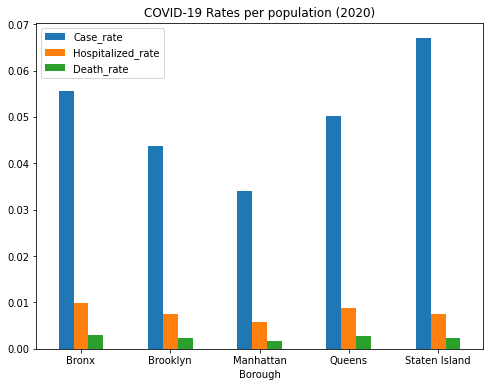

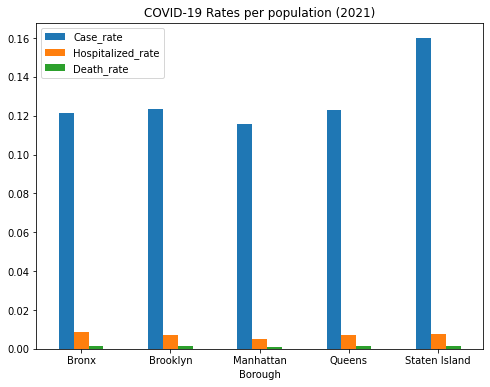

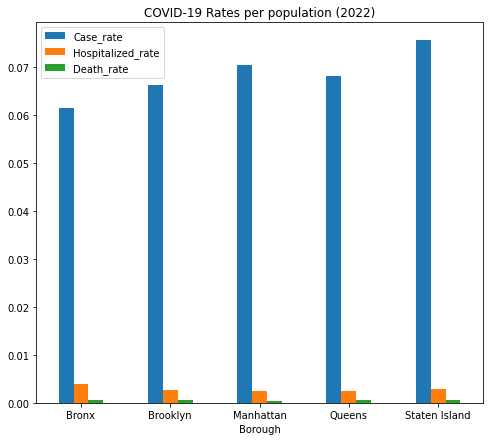

In [75]:
#get dataframe for each year
#2020
import seaborn as sns
covid_2020 = (covid_mod_df.iloc[:5]).drop(['Year'], axis=1)

#2021

covid_2021 = (covid_mod_df.iloc[5:10]).drop(['Year'], axis=1)

#2022
covid_2022 = (covid_mod_df.iloc[10:]).drop(['Year'], axis=1)

#check
#covid_2022

# sns.catplot(x = 'Borough',       # x variable name
#             y = 'Case_rate',       # y variable name
#             hue = "covid_2020.columns[1:]",  # group variable name
#             data = covid_2022,     # dataframe to plot
#             kind = "bar")
                                         
#plot histogram of covid cases
plt.rcParams["figure.figsize"] = (8,6)
covid_2020.set_index('Borough').plot.bar(rot = 0)
plt.title('COVID-19 Rates per population (2020)')
plt.show()

#2021
plt.rcParams["figure.figsize"] = (8,6)
covid_2021.set_index('Borough').plot.bar(rot = 0)
plt.title('COVID-19 Rates per population (2021)')
plt.show()

#2022
plt.rcParams["figure.figsize"] = (8,7)
covid_2022.set_index('Borough').plot.bar(rot = 0)
plt.title('COVID-19 Rates per population (2022)')
plt.show()

In [77]:
#get latitude, longitude of New York city
latitude = 40.730610
longitude  = -73.935242

# create map of NYC using latitude and longitude values
map_NYC = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(cities_final['latitude'], cities_final['longitude'], cities_final['borough'], cities_final['Neighbourhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_NYC)  
    
map_NYC